# Projet de cursus : Système Anti-Malware 
### Une approche utilisant la combinaisaon de modèles de deep learning et de machine learning pour la classification des malwares

**Auteurs :** M. Gosselin, Y. Emeriau, P. Ledermann, T. Boussin

**Classe :** 5CDI

**Année académique :** 2023-2024



Basé sur le papier de recherche : 

"Towards Building an Intelligent Anti-Malware System: A Deep Learning Approach using Support Vector Machine (SVM) for Malware Classification
Abien Fred M. Agarap"

# Introduction

L'objectif du projet est d'essayer de classifier des fichiers binaires de différent type de malwares. Le dataset que nous utilisons représentent les fichiers binaires de ces malwares sous formes d'image en grayscale.



![Capture d'écran 2024-01-16 153220.png](<attachment:Capture d'écran 2024-01-16 153220.png>)
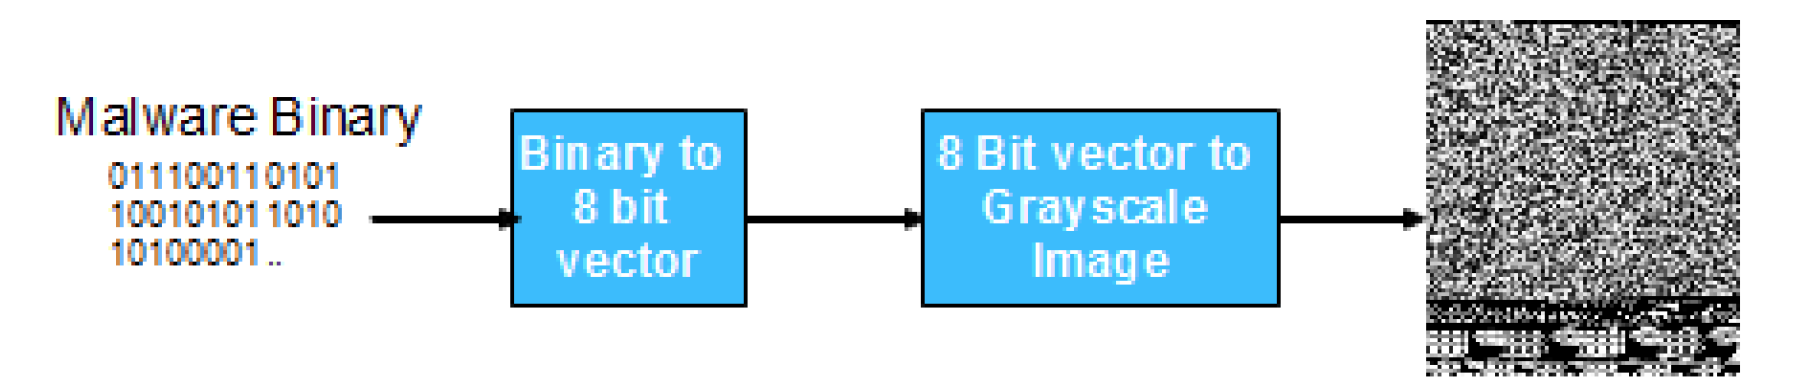

Le dataset contient 9.339 images correspondant à 25 différentstype de malwares.

## Catégories de malware du dataset

### Composeurs (Dialer)
- **Adialer.C:** Ce type de malware est conçu pour composer des numéros de téléphone surtaxés sans le consentement de l'utilisateur, entraînant des frais non autorisés.
- **Dialplatform.B:** Une autre variante de composeur, probablement avec des caractéristiques similaires consistant à composer des numéros de téléphone surtaxés sans autorisation.
- **Instantaccess:** Un composeur qui pourrait fournir un accès non autorisé à certains services ou ressources.

### Porte dérobée (Backdoor)
- **Agent.FYI:** Les portes dérobées sont conçues pour fournir un accès non autorisé à un système. Cette variante peut ouvrir une "porte dérobée" pour les attaquants à distance.
- **Rbot!gen:** Une autre variante de porte dérobée, probablement avec ses propres caractéristiques d'accès non autorisé.

### Ver (Worm)
- **Allaple.A et Allaple.L:** Les vers sont des malwares auto-réplicatifs qui se propagent à travers les réseaux. Ces variantes peuvent avoir des mécanismes de propagation et des charges utiles différents.
- **AutoIT Autorun.K et VB.AT:** Des vers qui peuvent utiliser des langages de script comme AutoIT ou Visual Basic pour la propagation.
- **Yuner.A:** Une autre variante de ver avec ses propres caractéristiques.

### Cheval de Troie (Trojan)
- **Alueron.gen!J, C2Lop.P, C2Lop.gen!G, Dontovo.A, Malex.gen!J, Obfuscator.AD, Skintrim.N, Swizzor.gen!E, Swizzor.gen!I, Wintrim.BX:** Les chevaux de Troie sont déguisés en logiciels légitimes mais contiennent un code malveillant. Chacune de ces variantes peut avoir des fonctions différentes, telles que le téléchargement de malwares supplémentaires, le vol d'informations ou la fourniture d'un accès non autorisé.

### Rogue (Faux)
- **Fakerean:** Les malwares faux se font passer pour des logiciels de sécurité légitimes, trompant les utilisateurs pour qu'ils paient pour des services factices.

### PWS (Stealer de mots de passe)
- **Lolyda.AA et Lolyda.AT:** Les stealers de mots de passe sont conçus pour capturer des informations sensibles, telles que les identifiants de connexion. Les variantes peuvent différer dans leurs méthodes ou leurs cibles.


## Partie 1 : Essai d'un modèle convolutif simple 

Un CNN, ou Convolutional Neural Network, est un type de réseau de neurones profonds conçu spécifiquement pour le traitement de données structurées en grille, telles que des images. Il est particulièrement efficace pour la reconnaissance visuelle et la classification d'objets dans des images. Les CNN utilisent des opérations de convolution pour extraire des caractéristiques importantes des données en appliquant des filtres spécifiques. Ces filtres permettent de détecter des motifs comme des bords, des textures et d'autres structures visuelles. Les couches de convolution sont souvent suivies de couches de pooling pour réduire la dimension spatiale des données. Enfin, des couches entièrement connectées peuvent être utilisées pour la classification finale. En résumé, un CNN est une architecture de réseau de neurones adaptée au traitement efficace des données en grille, comme les images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Nous commençons par charger les images et séparer les données X et leur label respectif y

In [2]:
import numpy as np

# Load the NPZ file
data = np.load('images_malware.npz', allow_pickle=True)

binaries = data['arr']

# Initialize empty lists for X and y
X = []
y = []

for i in binaries:
    X.append(i[0])
    y.append(i[1])


On affiche ensuite quelques images aléatoire du dataset

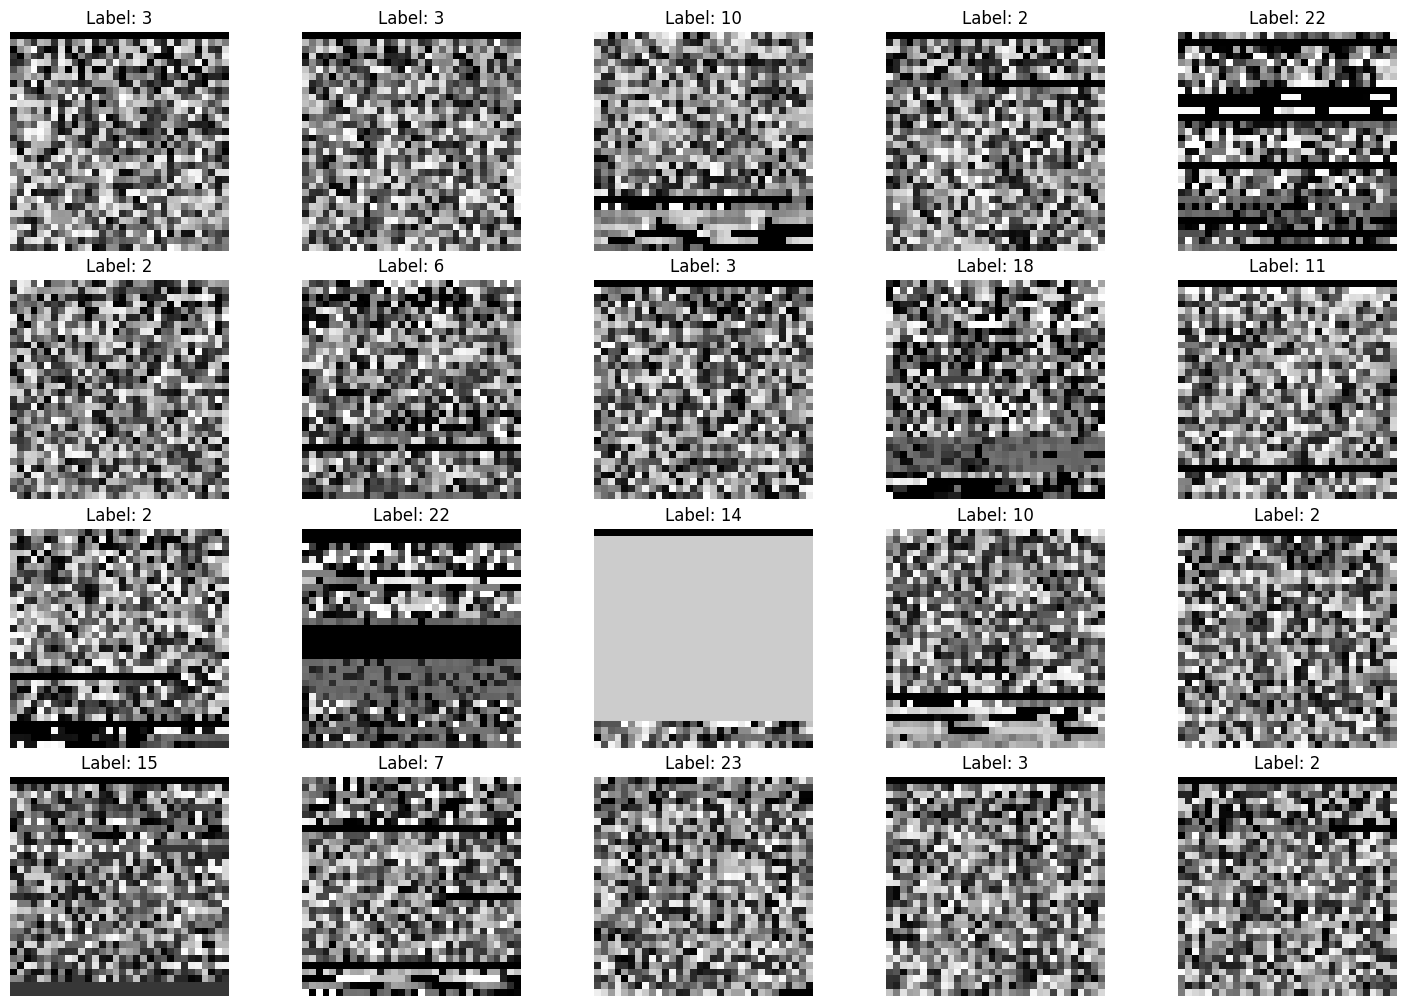

In [3]:
# Récupérer les données
images = data['arr'][:, 0]  # Supposons que les images sont dans la première colonne
labels = data['arr'][:, 1]  # Supposons que les étiquettes sont dans la deuxième colonne

# Nombre total d'images dans le dataset
total_images = len(images)

# Sélectionner 20 indices au hasard
random_indices = np.random.choice(total_images, size=20, replace=False)

# Afficher les images sélectionnées aléatoirement avec leurs étiquettes
num_images_per_row = 5
num_rows = (len(random_indices) - 1) // num_images_per_row + 1

plt.figure(figsize=(15, 10))  # Taille de la figure

for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(images[idx], cmap='gray')  # Affichage en nuances de gris
    plt.title(f'Label: {labels[idx]}')
    plt.axis('off')  # Désactiver les axes

plt.tight_layout(pad=0.5)  # Ajuster la disposition pour un espacement optimal
plt.show()

Comme nous sommes en grayscale, la matrice qui compose chaque image contient 1 canal de valeur allant de 0 à 255. Nous pouvons la normaliser simplement en divisant chaque pixel par 255. Nous obtenons alors des matrices avec des valeurs entre 0 et 1 qui faciliterons l'entrainement du modèle.

In [4]:
X_norm= [matrix / 255.0 for matrix in X]

On sépare X et y et batch de train et de test.

In [6]:
# Diviser les données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
images, test_images, labels, test_labels = train_test_split(X_norm, y, test_size=0.2, random_state=42)


images = np.array(images)
test_images = np.array(test_images)
labels = np.array(labels)
test_labels = np.array(test_labels)

print("Data Shape Image Tensor :", images.shape)
print("Data Shape Test Image Tensor :", test_images.shape)
print("Data Shape Label Tensor :", labels.shape)
print("Data Shape Test Label Tensor :", test_labels.shape)

Data Shape Image Tensor : (7471, 32, 32)
Data Shape Test Image Tensor : (1868, 32, 32)
Data Shape Label Tensor : (7471,)
Data Shape Test Label Tensor : (1868,)


Comme nous sommes en classification multiclasse, nous devons convertir la valeur du label en un vecteur de catégorie. Par exemple label = 2 -->> [0 1 0 0 ... 0 0]

In [14]:
from tensorflow.keras.utils import to_categorical

categorical_labels = to_categorical(labels)
categorical_test_labels = to_categorical(test_labels)


[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Nous définissons un modèle simple : 4 couches convolutives et deux couches simples pour la classification.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Nadam, Adadelta

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    
    Dense(32, activation='relu'),

    Dense(25, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Nadam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

early_stopping = EarlyStopping(monitor='val_accuracy', patience=500, restore_best_weights=True)

# Train the model
history = model.fit(images, categorical_labels, epochs=20, batch_size=32, validation_data=(test_images, categorical_test_labels))#, callbacks=[early_stopping])

Epoch 1/20
234/234 [==============================] - 6s 21ms/step - loss: 2.4925 - accuracy: 0.3290 - val_loss: 1.9491 - val_accuracy: 0.4647
Epoch 2/20
234/234 [==============================] - 5s 20ms/step - loss: 1.4114 - accuracy: 0.5808 - val_loss: 1.0597 - val_accuracy: 0.6531
Epoch 3/20
234/234 [==============================] - 5s 20ms/step - loss: 0.9263 - accuracy: 0.7077 - val_loss: 0.7914 - val_accuracy: 0.7286
Epoch 4/20
234/234 [==============================] - 5s 20ms/step - loss: 0.7837 - accuracy: 0.7394 - val_loss: 0.7261 - val_accuracy: 0.7452
Epoch 5/20
234/234 [==============================] - 7s 31ms/step - loss: 0.6777 - accuracy: 0.7655 - val_loss: 0.6579 - val_accuracy: 0.7628
Epoch 6/20
234/234 [==============================] - 7s 31ms/step - loss: 0.6414 - accuracy: 0.7779 - val_loss: 0.6423 - val_accuracy: 0.7725
Epoch 7/20
234/234 [==============================] - 7s 31ms/step - loss: 0.5930 - accuracy: 0.7841 - val_loss: 0.5618 - val_accuracy: 0.7891

On affiche les courbes de l'entrainement du modèle.

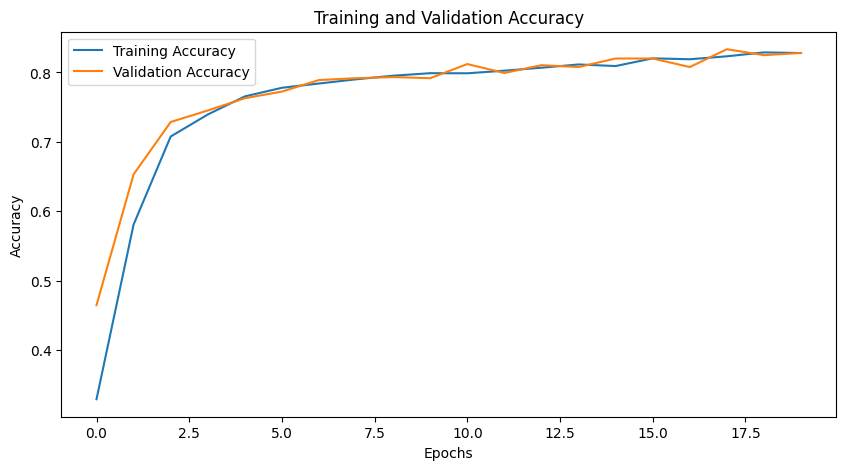

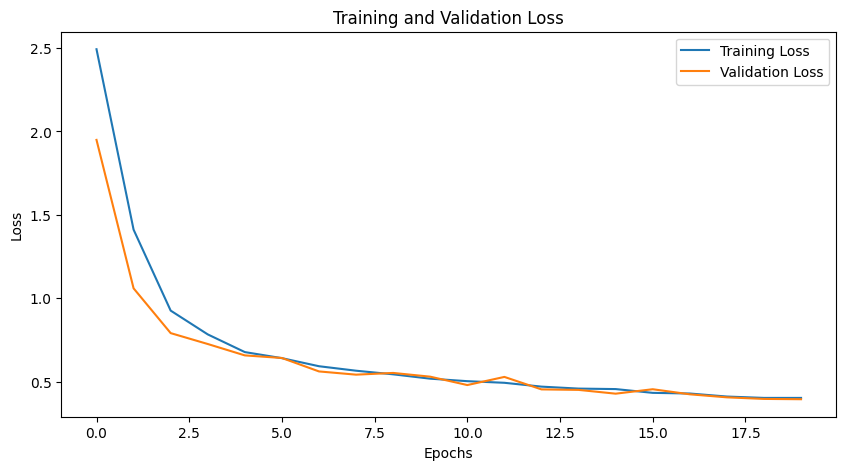

In [28]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history after model.fit()
# Accessing the accuracy and loss values
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Nous obtenons de bon résultats, environ 80% de précision pour ce modèle. On constate que l'on pourrait diffilement faire mieux avec un simple modèle convolutif. 80 % signifie que nous avons 1 mauvaise classification sur 5. Or dans notre cas nous travaillons pour un domaine rigoureux. Nous visons des résultats allant au moins jusqu'à 95% de précision.

Dans la prochaine partie, nous testons un modèle combinant Deep Learning et Machine Learning.